In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/132 [00:01<?, ?it/s]


torch.Size([2, 16, 630, 630])

In [3]:
# from tqdm import tqdm

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.batch_size,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
# # train_nshuffle_loader = DataLoader(
# #     train_nshuffle_dataset,
# #     batch_size=1,
# #     shuffle=True,
# #     drop_last=True,
# #     pin_memory=True,
# #     num_workers=CFG.num_workers,
# # )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )

# for data in tqdm(train_loader):
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

# normalized_tomogram.shape

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

<All keys matched successfully>

In [5]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [7]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([2, 16, 640, 640])

In [12]:
best_model = None
best_constant = 0
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    for constant in tqdm(np.linspace(0.1, 0.9, 15)):
        valid_pred_array = []
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }
        for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
            pred_df = inference2pos(
                pred_segmask=valid_inferenced_array[exp_name],
                exp_name=exp_name,
                sikii_dict=sikii,
            )
            valid_pred_array.append(pred_df)

        valid_pred_array = pd.concat(valid_pred_array)

        if len(valid_pred_array) != 0:
            score_ = score(
                valid_pred_array,
                valid_gt_array,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            if score_ > best_score:
                b_score = score_
                b_constant = constant

        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()

    print("constant", b_constant, "score", b_score)

    if b_score > best_score:
        best_constant = b_constant
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.9 score 0.1446808510638298
train-epoch-loss:0.0211 valid-epoch-loss:0.0249 valid-beta4-score:0.1447


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.5571428571428572 score 0.25941650910657443
train-epoch-loss:0.0238 valid-epoch-loss:0.0207 valid-beta4-score:0.2594


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0.9 score 0.27677887855934685
train-epoch-loss:0.0195 valid-epoch-loss:0.0208 valid-beta4-score:0.2768


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.3857142857142858 score 0.3235242157276637
train-epoch-loss:0.0203 valid-epoch-loss:0.0042 valid-beta4-score:0.3235


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.3857142857142858 score 0.3334517507571517
train-epoch-loss:0.0217 valid-epoch-loss:0.0035 valid-beta4-score:0.3335


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.6714285714285715 score 0.37897972017198284
train-epoch-loss:0.0196 valid-epoch-loss:0.0195 valid-beta4-score:0.3790


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0.27142857142857146 score 0.39541596801535356
train-epoch-loss:0.0236 valid-epoch-loss:0.0161 valid-beta4-score:0.3954


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.6714285714285715 score 0.40267985982271703
train-epoch-loss:0.0185 valid-epoch-loss:0.0070 valid-beta4-score:0.4027


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.27142857142857146 score 0.4237676720555889
train-epoch-loss:0.0214 valid-epoch-loss:0.0157 valid-beta4-score:0.4238


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0231 valid-epoch-loss:0.0009 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.3857142857142858 score 0.5275906959930827
train-epoch-loss:0.0215 valid-epoch-loss:0.0077 valid-beta4-score:0.5276


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.3285714285714286 score 0.5409193770342143
train-epoch-loss:0.0197 valid-epoch-loss:0.0004 valid-beta4-score:0.5409


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0 score -100
train-epoch-loss:0.0198 valid-epoch-loss:0.0095 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0 score -100
train-epoch-loss:0.0204 valid-epoch-loss:0.0188 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0200 valid-epoch-loss:0.0190 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0221 valid-epoch-loss:0.0208 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0 score -100
train-epoch-loss:0.0213 valid-epoch-loss:0.0003 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0164 valid-epoch-loss:0.0170 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.44285714285714284 score 0.592809019109966
train-epoch-loss:0.0184 valid-epoch-loss:0.0032 valid-beta4-score:0.5928


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0 score -100
train-epoch-loss:0.0228 valid-epoch-loss:0.0212 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0.5571428571428572 score 0.6500575670864882
train-epoch-loss:0.0186 valid-epoch-loss:0.0137 valid-beta4-score:0.6501


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


constant 0 score -100
train-epoch-loss:0.0197 valid-epoch-loss:0.0153 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0 score -100
train-epoch-loss:0.0190 valid-epoch-loss:0.0035 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0 score -100
train-epoch-loss:0.0222 valid-epoch-loss:0.0216 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0 score -100
train-epoch-loss:0.0186 valid-epoch-loss:0.0052 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0 score -100
train-epoch-loss:0.0203 valid-epoch-loss:0.0086 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0 score -100
train-epoch-loss:0.0172 valid-epoch-loss:0.0175 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0 score -100
train-epoch-loss:0.0200 valid-epoch-loss:0.0153 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0 score -100
train-epoch-loss:0.0165 valid-epoch-loss:0.0180 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0 score -100
train-epoch-loss:0.0199 valid-epoch-loss:0.0197 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0 score -100
train-epoch-loss:0.0178 valid-epoch-loss:0.0021 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0194 valid-epoch-loss:0.0068 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0197 valid-epoch-loss:0.0028 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0164 valid-epoch-loss:0.0138 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0189 valid-epoch-loss:0.0003 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0 score -100
train-epoch-loss:0.0201 valid-epoch-loss:0.0143 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0177 valid-epoch-loss:0.0189 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0 score -100
train-epoch-loss:0.0180 valid-epoch-loss:0.0017 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0150 valid-epoch-loss:0.0083 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0 score -100
train-epoch-loss:0.0182 valid-epoch-loss:0.0004 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0 score -100
train-epoch-loss:0.0171 valid-epoch-loss:0.0044 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0181 valid-epoch-loss:0.0055 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0161 valid-epoch-loss:0.0002 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0 score -100
train-epoch-loss:0.0151 valid-epoch-loss:0.0020 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0145 valid-epoch-loss:0.0166 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0196 valid-epoch-loss:0.0183 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0 score -100
train-epoch-loss:0.0154 valid-epoch-loss:0.0076 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.6142857142857143 score 0.661422094641995
train-epoch-loss:0.0175 valid-epoch-loss:0.0006 valid-beta4-score:0.6614


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0155 valid-epoch-loss:0.0048 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0145 valid-epoch-loss:0.0041 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0190 valid-epoch-loss:0.0172 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0 score -100
train-epoch-loss:0.0174 valid-epoch-loss:0.0178 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0 score -100
train-epoch-loss:0.0168 valid-epoch-loss:0.0174 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0 score -100
train-epoch-loss:0.0153 valid-epoch-loss:0.0049 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0 score -100
train-epoch-loss:0.0151 valid-epoch-loss:0.0159 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0 score -100
train-epoch-loss:0.0144 valid-epoch-loss:0.0174 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0 score -100
train-epoch-loss:0.0157 valid-epoch-loss:0.0039 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0175 valid-epoch-loss:0.0002 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0182 valid-epoch-loss:0.0167 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0157 valid-epoch-loss:0.0120 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0154 valid-epoch-loss:0.0042 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0 score -100
train-epoch-loss:0.0137 valid-epoch-loss:0.0176 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0 score -100
train-epoch-loss:0.0150 valid-epoch-loss:0.0122 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0158 valid-epoch-loss:0.0002 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0 score -100
train-epoch-loss:0.0131 valid-epoch-loss:0.0060 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


constant 0 score -100
train-epoch-loss:0.0136 valid-epoch-loss:0.0197 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0 score -100
train-epoch-loss:0.0147 valid-epoch-loss:0.0186 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0 score -100
train-epoch-loss:0.0148 valid-epoch-loss:0.0203 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0.3857142857142858 score 0.6964942123880435
train-epoch-loss:0.0151 valid-epoch-loss:0.0194 valid-beta4-score:0.6965


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0 score -100
train-epoch-loss:0.0137 valid-epoch-loss:0.0052 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0153 valid-epoch-loss:0.0031 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0153 valid-epoch-loss:0.0071 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


constant 0 score -100
train-epoch-loss:0.0143 valid-epoch-loss:0.0177 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0151 valid-epoch-loss:0.0002 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0161 valid-epoch-loss:0.0001 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


constant 0 score -100
train-epoch-loss:0.0132 valid-epoch-loss:0.0016 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0 score -100
train-epoch-loss:0.0161 valid-epoch-loss:0.0016 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


constant 0 score -100
train-epoch-loss:0.0152 valid-epoch-loss:0.0032 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


constant 0 score -100
train-epoch-loss:0.0173 valid-epoch-loss:0.0001 valid-beta4-score:-100.0000


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]

constant 0 score -100
train-epoch-loss:0.0149 valid-epoch-loss:0.0193 valid-beta4-score:-100.0000


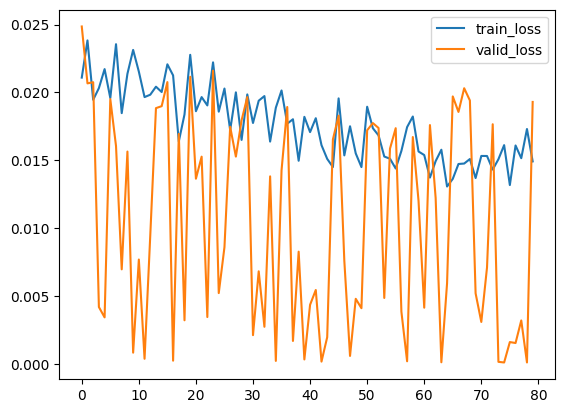

In [13]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

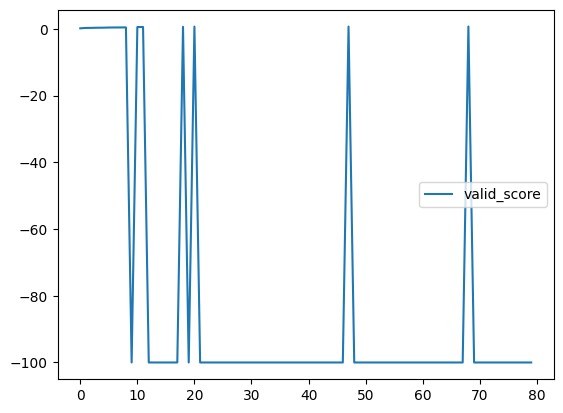

In [14]:
# train_scoreとvalid_scoreのプロット
# plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [15]:
random.random()

0.9536093117873552